# Gaussian Processes

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING']="1"
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
import torch
import gpytorch

%matplotlib inline

In [2]:
print(torch.cuda.get_device_name() if torch.cuda.is_available() else "No GPU")
print(os.cpu_count())
!nvidia-smi

NVIDIA GeForce RTX 2080 Ti
8
Sat Apr 16 14:27:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:05:00.0 Off |                  N/A |
| 48%   76C    P2   155W / 250W |   3887MiB / 11019MiB |     14%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                           

In [3]:
dataset = pd.read_pickle('../Dataset/baseline_dataset.gz')
pd.set_option("display.max.columns", None)
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45293 entries, 0 to 45292
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MM             45293 non-null  int64  
 1   DD             45293 non-null  int64  
 2   HH             45293 non-null  int64  
 3   LOW_IMPACT     45293 non-null  bool   
 4   MID_IMPACT     45293 non-null  bool   
 5   BIG_IMPACT     45293 non-null  bool   
 6   DIRECT_STRIKE  45293 non-null  bool   
 7   00LAT          45293 non-null  float32
 8   00LON          45293 non-null  float32
 9   00WIND         45293 non-null  int32  
 10  06LAT          45293 non-null  float32
 11  06LON          45293 non-null  float32
 12  06WIND         45293 non-null  int32  
 13  12LAT          45293 non-null  float32
 14  12LON          45293 non-null  float32
 15  12WIND         45293 non-null  int32  
 16  18LAT          45293 non-null  float32
 17  18LON          45293 non-null  float32
 18  18WIND

In [4]:
# Constants
TRAIN_RATIO = 0.9
NUM_EPOCHS = 100
LR = 0.1
BATCH_SIZE = 512

In [5]:
# imports
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, precision_recall_curve, classification_report, brier_score_loss
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

# test-dev-train split
def separateDataset(dataset, train_ratio):
    '''
    Takes in a dataset (pandas df) and a ratio value, returns a dictionary containing the separated dataset.
    Key "train" = train set, "dev" = dev set (size = train ratio * (sizeof input df - test set)), "test" = test set (size = train ratio * sizeof input df)
    '''
    train_dev_set, test_set = train_test_split(dataset, train_size=train_ratio)
    train_set, dev_set = train_test_split(train_dev_set, train_size=train_ratio)
    print("Training set size: {0}; Dev set size: {1}; Testing set size: {2}".format(len(train_set), len(dev_set), len(test_set)))
    return { "train": train_set, "dev": dev_set, "test": test_set }

def pandasToXY(dataframe):
    '''
    converts the given pandas df to X and Y sub-arrays. X is pandas df, Y is np int array.
    note: the range of columns to select as Y must be double checked when a different dataset is used.
    '''
    X = dataframe.drop(['LOW_IMPACT', 'MID_IMPACT', 'BIG_IMPACT', 'DIRECT_STRIKE'], axis=1)
    Y = np.asarray(dataframe.iloc[:,3:7]).astype(int)
    return X, Y

# split
splitDataset = separateDataset(dataset, TRAIN_RATIO)
# to XY
train_X, train_Y = pandasToXY(splitDataset["train"])
dev_X, dev_Y = pandasToXY(splitDataset["dev"])
# to tensor
train_X = torch.tensor(StandardScaler().fit_transform(train_X)).float()
train_Y = torch.tensor(train_Y[:,0]).float()
dev_X = torch.tensor(StandardScaler().fit_transform(dev_X)).float()
dev_Y = torch.tensor(dev_Y[:,0]).float()
# to dataloader
train_loader = DataLoader(TensorDataset(train_X, train_Y), batch_size=BATCH_SIZE, shuffle=True)
dev_loader = DataLoader(TensorDataset(dev_X, dev_Y), batch_size=BATCH_SIZE, shuffle=True)

Training set size: 36686; Dev set size: 4077; Testing set size: 4530


In [6]:
from scipy.special import expit

def regression_predict(preds, method='clip'):
    '''
    Takes in an array of raw predictions and optionally a method argument (must be either "sigmoid" or "clip");
    Returns predictions made by the model that have been rescaled to fall within [0,1] using the specified method.
    Note that the GP model is treated as if it were a regressor.
    '''
    # method specifies how to handle inputs outside of 0-1 range: clip to 0 or 1, or pass through sigmoid
    if method == 'clip':
        preds = np.clip(preds, 0, 1)
    elif method == 'sigmoid':
        preds = expit(preds)
    return preds

def regressor_find_thresholds(all_preds, datasetY, method='clip'):
    '''
    Takes in an array of predictions, a target set Y and optionally a scaling method;
    returns the best decision thresholds and corresponding f1-scores;
    displays the values and a precision recall curve.
    '''
    best_thresholds = []
    best_f1_scores = []
    for i in range(4):
        precision, recall, thresholds = precision_recall_curve(datasetY[:,i], all_preds[:,i])
        fscore = (2 * precision * recall) / (precision + recall)
        ix = np.nanargmax(fscore)
        best_thresholds.append(thresholds[ix])
        best_f1_scores.append(fscore[ix])
        print('Best Threshold={0:.05f}, F-Score={1:.05f}'.format(thresholds[ix], fscore[ix]))

    # plot the precision-recall curve for the model
    plt.plot(recall, precision, marker='.', label='PR curve')
    plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    
    return best_thresholds, best_f1_scores

In [7]:
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy, IndependentMultitaskVariationalStrategy, LMCVariationalStrategy

class ApproximateGPModel(gpytorch.models.ApproximateGP):
    '''An approximate Gaussian process model is defined here'''
    def __init__(self, inducing_points):        
        variational_distribution = CholeskyVariationalDistribution(
            inducing_points.size(0)#, batch_shape=torch.Size([2])
        )
        variational_strategy = VariationalStrategy(
                self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        
        '''LMCVariationalStrategy(
            VariationalStrategy(
                self, inducing_points, variational_distribution, learn_inducing_locations=True
            ),
            num_tasks=4, num_latents=2, latent_dim=-1
        )'''
        
        super(ApproximateGPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
            #batch_shape=torch.Size([2])
        )
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
likelihood = gpytorch.likelihoods.BernoulliLikelihood()
model = ApproximateGPModel(inducing_points=train_X[:5000,:])

In [8]:
model = model.cuda()
likelihood = likelihood.cuda()

In [9]:
model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()}, 
    {'params': likelihood.parameters()}
], lr=LR)
# optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_Y.size(0))
mll = gpytorch.mlls.PredictiveLogLikelihood(likelihood, model, num_data=train_Y.size(0))

for i in range(NUM_EPOCHS):
    
    running_loss = 0.0
    
    for j, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.cuda()
        targets = targets.cuda()        
        optimizer.zero_grad()
        output = model(inputs)
        loss = -mll(output, targets)
        loss.backward()        
        optimizer.step()
        running_loss += loss.item()
        
    average_loss = running_loss/len(train_loader)
        
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f' % ( #   noise: %.3f
        i + 1, NUM_EPOCHS, average_loss,
        model.covar_module.base_kernel.lengthscale.item()
        #model.covar_module.noise.item()
    ))

Iter 1/100 - Loss: 0.350   lengthscale: 1.942
Iter 2/100 - Loss: 0.244   lengthscale: 2.136
Iter 3/100 - Loss: 0.240   lengthscale: 2.042
Iter 4/100 - Loss: 0.239   lengthscale: 1.973
Iter 5/100 - Loss: 0.226   lengthscale: 1.827
Iter 6/100 - Loss: 0.218   lengthscale: 1.676
Iter 7/100 - Loss: 0.213   lengthscale: 1.677
Iter 8/100 - Loss: 0.210   lengthscale: 1.675
Iter 9/100 - Loss: 0.207   lengthscale: 1.666
Iter 10/100 - Loss: 0.205   lengthscale: 1.601
Iter 11/100 - Loss: 0.199   lengthscale: 1.646
Iter 12/100 - Loss: 0.199   lengthscale: 1.688
Iter 13/100 - Loss: 0.198   lengthscale: 1.733
Iter 14/100 - Loss: 0.194   lengthscale: 1.704
Iter 15/100 - Loss: 0.197   lengthscale: 1.572
Iter 16/100 - Loss: 0.198   lengthscale: 1.726
Iter 17/100 - Loss: 0.193   lengthscale: 1.693
Iter 18/100 - Loss: 0.193   lengthscale: 1.727
Iter 19/100 - Loss: 0.192   lengthscale: 1.675
Iter 20/100 - Loss: 0.189   lengthscale: 1.696
Iter 21/100 - Loss: 0.190   lengthscale: 1.794
Iter 22/100 - Loss: 0.

In [10]:
model.eval()
likelihood.eval()

all_preds = torch.tensor([])

with torch.no_grad():
    for j, (inputs, targets) in enumerate(dev_loader):
        inputs = inputs.cuda()
        preds = likelihood(model(inputs))
        all_preds = torch.cat([all_preds, preds.probs.cpu()])
    
print(all_preds)

tensor([0.0151, 0.0247, 0.3820,  ..., 0.3566, 0.0266, 0.2896])


In [11]:
all_preds = np.clip(all_preds, 0, 1)

precision, recall, thresholds = precision_recall_curve(dev_Y, all_preds)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.nanargmax(fscore)
print('Best Threshold={0:.05f}, F-Score={1:.05f}'.format(thresholds[ix], fscore[ix]))

Best Threshold=0.00012, F-Score=0.16499


/tmp/.u3556490/ipykernel_9610/3743630220.py:4: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


Best Threshold=0.51872, F-Score=0.16474
Best Threshold=0.50932, F-Score=0.13912
Best Threshold=0.49978, F-Score=0.05287
Best Threshold=0.50370, F-Score=0.04706


/tmp/ipykernel_20535/4130612801.py:16: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/tmp/ipykernel_20535/4130612801.py:16: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/tmp/ipykernel_20535/4130612801.py:16: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/tmp/ipykernel_20535/4130612801.py:16: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


([0.5187237, 0.5093235, 0.49978086, 0.5037002],
 [0.16473791695030635,
  0.13911742707554228,
  0.05286574195236849,
  0.047058823529411764])

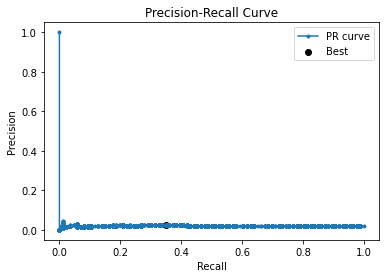

In [77]:
preds = regression_predict(means.numpy(), method='sigmoid')
regressor_find_thresholds(preds, dev_Y, method='sigmoid')

In [12]:
model = model.cpu()
likelihood = likelihood.cpu()
torch.cuda.empty_cache()